### Support Vector Machines Practice Lab

This lab will take a look at support vector machines, in doing so you will explore how changing the hyper-parameters can help improve performance. This lab will use `parsnip` for model fitting and `recipes` and `workflows` to perform the transformations, and tune and dials to tune the hyper-parameters of the model. In other words this lab and subsequent programming assignment must be done in the `Tidy Models` Programming Framework. 

This lab will run through a few specifications, then after running through each portion you will begin the official programming assignment. 

In [1]:
library(tidymodels)
library(ISLR2)
library(kernlab)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ recipes      1.0.5
✔ dials        1.2.0     ✔ rsample      1.1.1
✔ dplyr        1.1.2     ✔ tibble       3.2.1
✔ ggplot2      3.4.2     ✔ tidyr        1.3.0
✔ infer        1.0.4     ✔ tune         1.1.1
✔ modeldata    1.1.0     ✔ workflows    1.1.3
✔ parsnip      1.1.0     ✔ workflowsets 1.0.1
✔ purrr        1.0.1     ✔ yardstick    1.1.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.


Attaching package: ‘kernlab’


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:scales’:

    alpha




For this lab, begin by creating a synthetic data set. You will use some normally distributed data with an added offset to create 2 separate classes.

In [2]:
set.seed(1)
sim_data <- tibble(
  x1 = rnorm(40),
  x2 = rnorm(40),
  y  = factor(rep(c(-1, 1), 20))
) %>%
  mutate(x1 = ifelse(y == 1, x1 + 1.5, x1),
         x2 = ifelse(y == 1, x2 + 1.5, x2))

Plotting it shows that you are having two slightly overlapping classes.

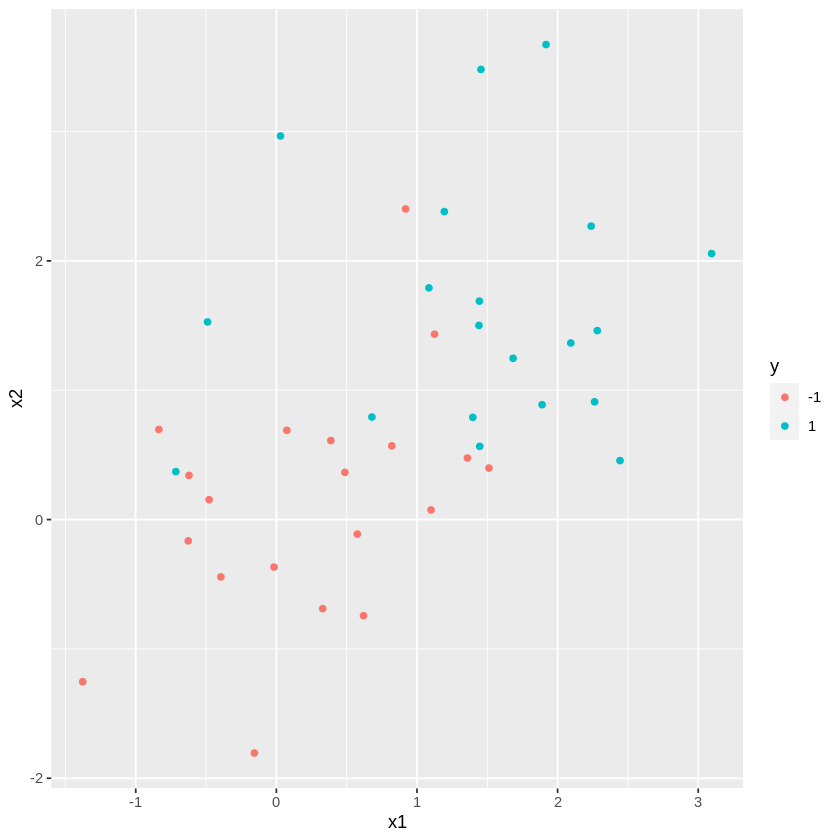

In [3]:
ggplot(sim_data, aes(x1, x2, color = y)) +
  geom_point()

You can then create a linear SVM specification by setting `degree = 1` in a polynomial SVM model. You furthermore `set scaled = FALSE` in set_engine() to have the engine scale the data for you. Once you get to it later you can be performing this scaling in a recipe instead.

Note that `set_engine()` can be used to pass in additional arguments directly to the underlying engine. In this case, you are passing in `scaled = FALSE` to `kernlab::ksvm()` which is the engine function.

In [4]:
svm_linear_spec <- svm_poly(degree = 1) %>%
  set_mode("classification") %>%
  set_engine("kernlab", scaled = FALSE)

Taking the specification, you can add a specific cost of 10 before fitting the model to the data. Using `set_args()` allows you to set the `cost` argument without modifying the model specification.

In [5]:
svm_linear_fit <- svm_linear_spec %>% 
  set_args(cost = 10) %>%
  fit(y ~ ., data = sim_data)

svm_linear_fit

parsnip model object

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 10 

Polynomial kernel function. 
 Hyperparameters : degree =  1  scale =  1  offset =  1 

Number of Support Vectors : 17 

Objective Function Value : -152.0188 
Training error : 0.125 
Probability model included. 

The `kernlab` models can be visualized using the `plot()` function if you load the `kernlab` package.

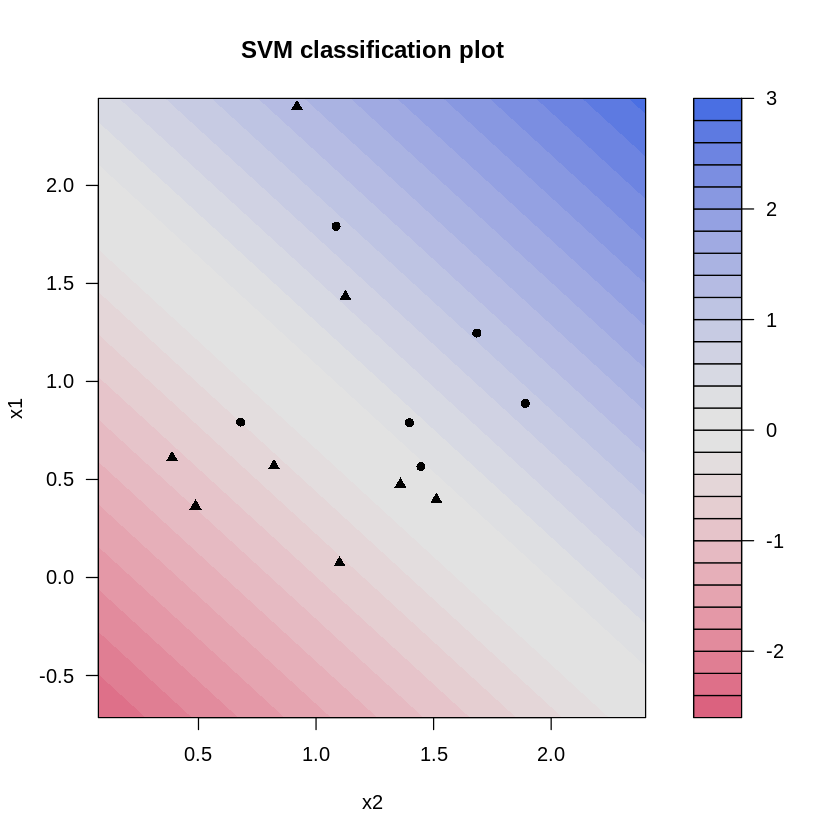

In [6]:
svm_linear_fit %>%
  extract_fit_engine() %>%
  plot()

Further, what if you instead used a smaller value of the `cost` parameter?

In [7]:
svm_linear_fit <- svm_linear_spec %>% 
  set_args(cost = 0.1) %>%
  fit(y ~ ., data = sim_data)

svm_linear_fit

parsnip model object

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 0.1 

Polynomial kernel function. 
 Hyperparameters : degree =  1  scale =  1  offset =  1 

Number of Support Vectors : 25 

Objective Function Value : -2.0376 
Training error : 0.15 
Probability model included. 

Now that a smaller value of the cost parameter is being used, you obtain a larger number of support vectors, because the margin is now wider.

Now go on ahead and set up a `tune_grid()` section to find the value of cost that leads to the highest accuracy for the SVM model.

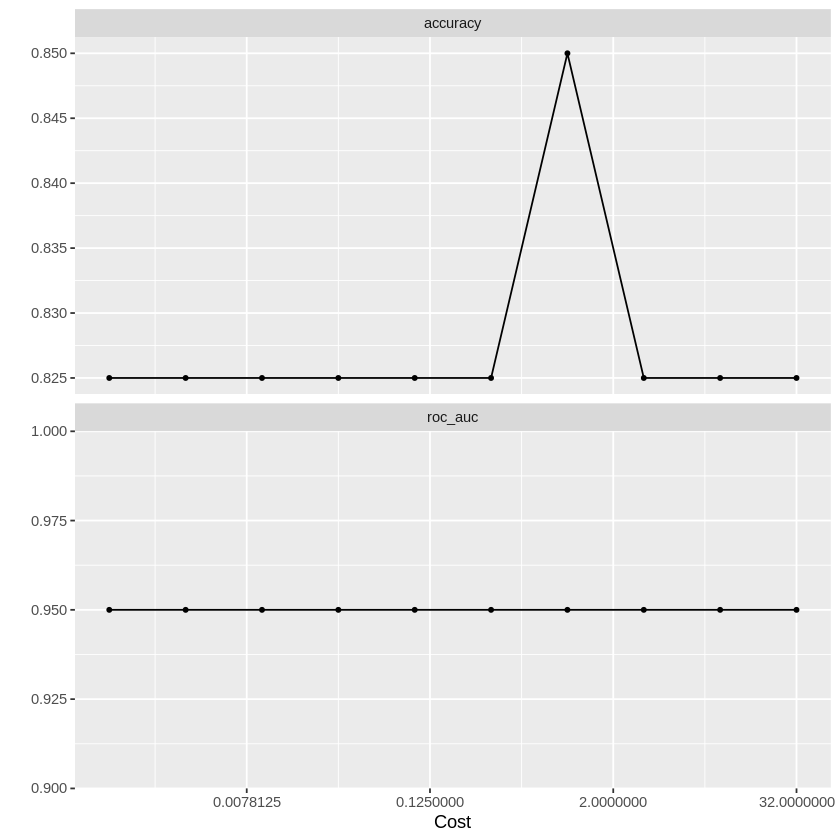

In [8]:
svm_linear_wf <- workflow() %>%
  add_model(svm_linear_spec %>% set_args(cost = tune())) %>%
  add_formula(y ~ .)

set.seed(1234)
sim_data_fold <- vfold_cv(sim_data, strata = y)

param_grid <- grid_regular(cost(), levels = 10)

tune_res <- tune_grid(
  svm_linear_wf, 
  resamples = sim_data_fold, 
  grid = param_grid
)

autoplot(tune_res)

Using the `tune_res` object and `select_best()` function allows you to find the value of `cost` that gives the best cross-validated accuracy. Finalize the workflow with `finalize_workflow()` and fit the new workflow on the data set.

In [9]:
best_cost <- select_best(tune_res, metric = "accuracy")

svm_linear_final <- finalize_workflow(svm_linear_wf, best_cost)

svm_linear_fit <- svm_linear_final %>% fit(sim_data)

You can now generate a different data set to act as the test data set. You will make ensure it is generated using the same model but with a different seed.

In [10]:
set.seed(2)
sim_data_test <- tibble(
  x1 = rnorm(20),
  x2 = rnorm(20),
  y  = factor(rep(c(-1, 1), 10))
) %>%
  mutate(x1 = ifelse(y == 1, x1 + 1.5, x1),
         x2 = ifelse(y == 1, x2 + 1.5, x2))

and accessing the model on this testing data set shows us that the model still performs very well.

In [11]:
augment(svm_linear_fit, new_data = sim_data_test) %>%
  conf_mat(truth = y, estimate = .pred_class)

          Truth
Prediction -1 1
        -1  8 3
        1   2 7